In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


## Data

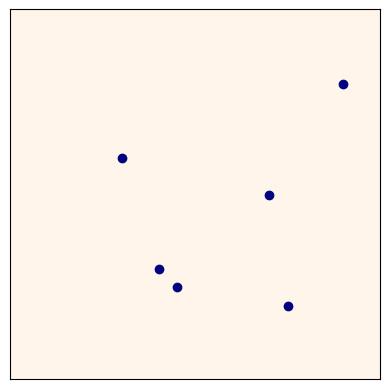

In [ ]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


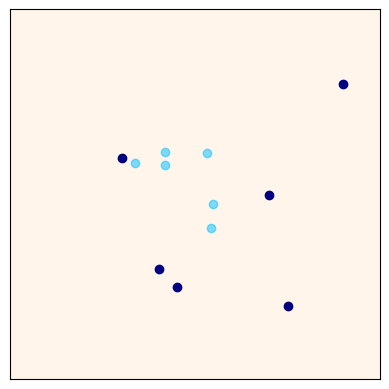

In [ ]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 6     # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

### ... ###
z = torch.randn(b, n_in)
x = G(z)


# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Gradient penalty

In [ ]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()


In [ ]:
def MMD(x, y , ):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    """
    print(rx.t().shape)
    print(ry.shape)
    print(zz.shape)
    """
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))


    #rbf kernel
    bandwidth_range = [10, 15, 20, 50]
    for a in bandwidth_range:
      XX += torch.exp(-0.5*dxx/a)
      YY += torch.exp(-0.5*dyy/a)
      XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

## Training

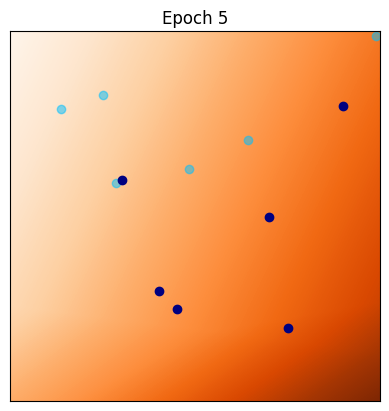

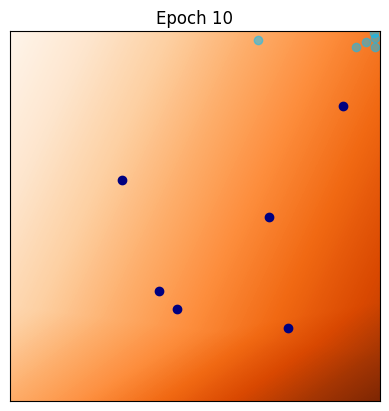

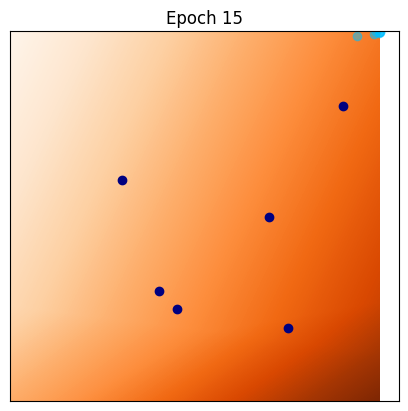

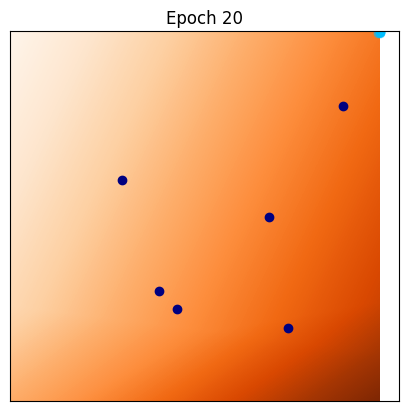

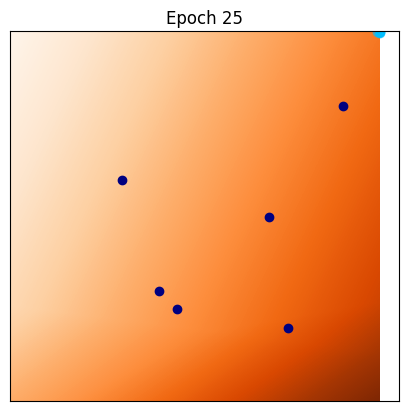

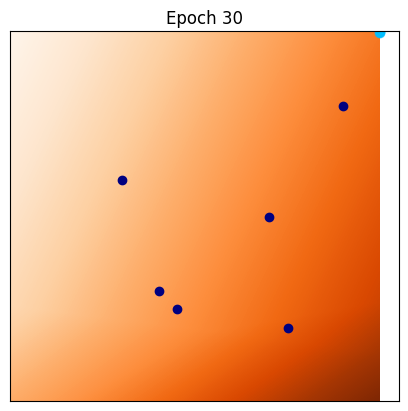

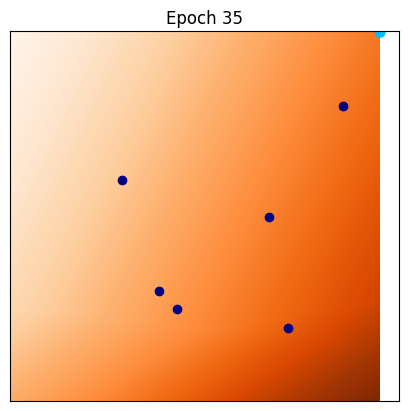

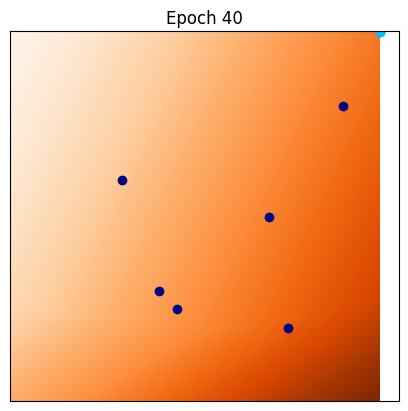

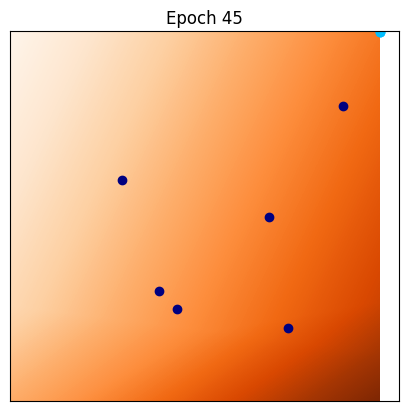

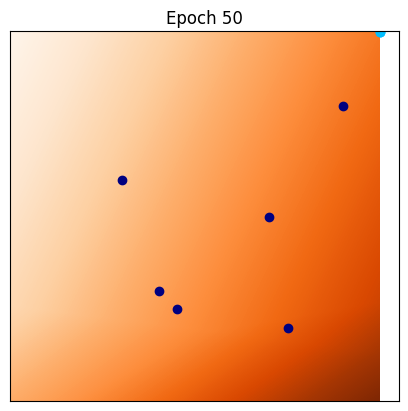

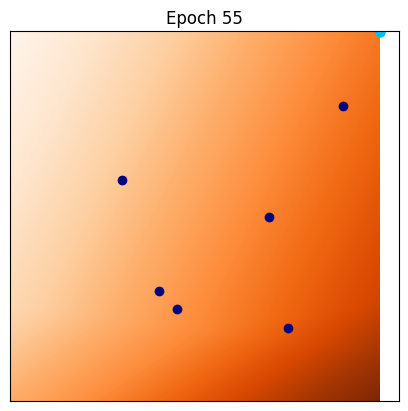

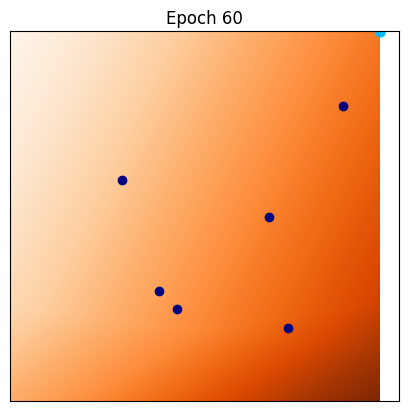

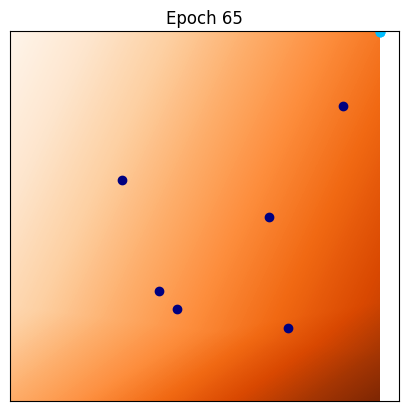

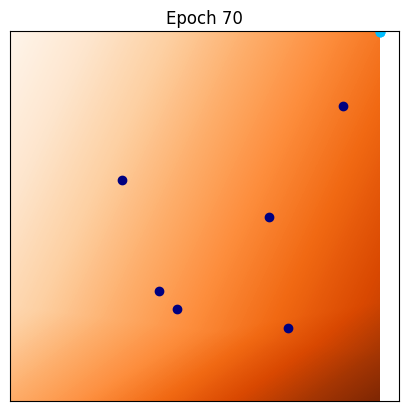

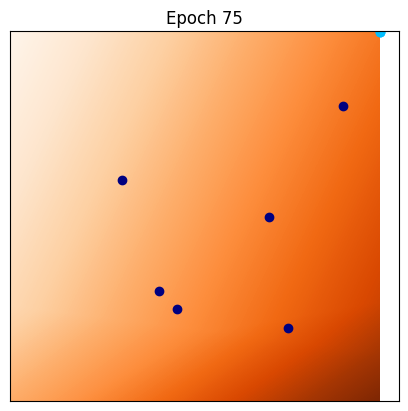

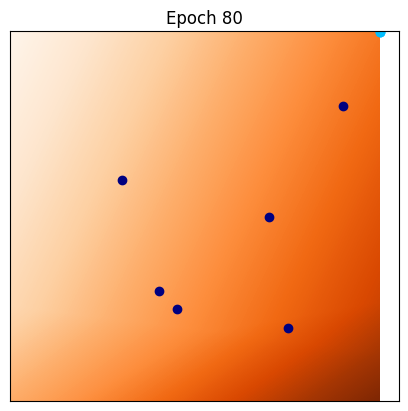

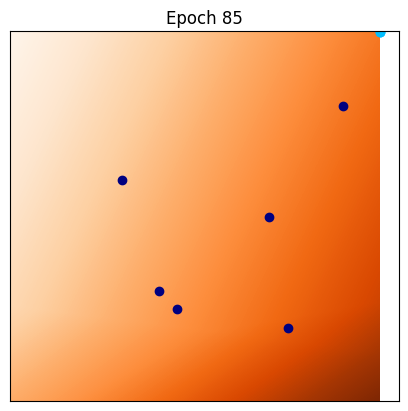

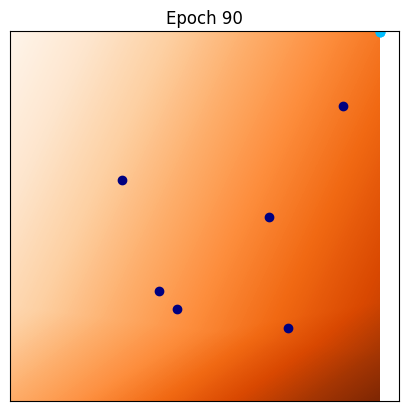

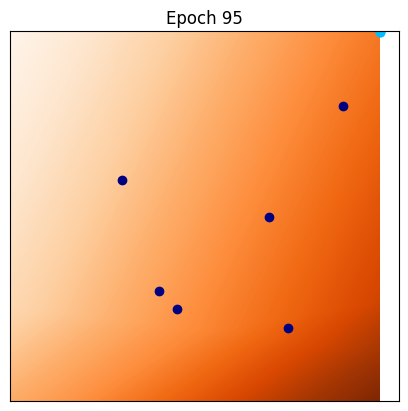

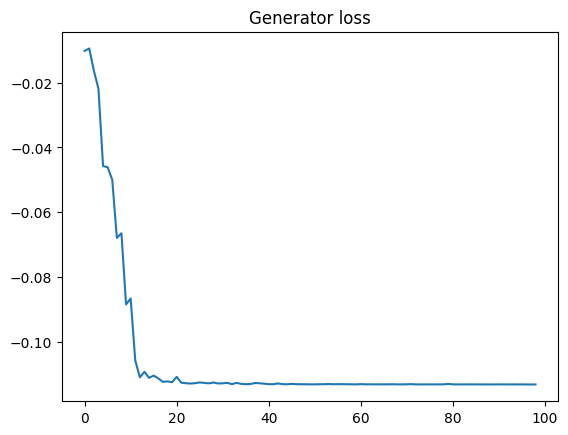

<All keys matched successfully>

In [ ]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1
KERNEL_TYPE = "multiscale"

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ###########################


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###
        z = torch.randn(b, n_in, device=device)
        optimG.zero_grad()
        # Generate fake data
        x = G(z)
        # Compute generator loss
        Gloss = -torch.mean(MMD(x,y))
        Gloss.backward()
        optimG.step()



    # Output training stats
    Glosses.append(Gloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

In [ ]:
def MMD(x, y):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    """
    print(rx.t().shape)
    print(ry.shape)
    print(zz.shape)
    """
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))


    #rbf kernel
    bandwidth_range = [10, 15, 20, 50]
    for a in bandwidth_range:
      XX += torch.exp(-0.5*dxx/a)
      YY += torch.exp(-0.5*dyy/a)
      XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

In [ ]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1
KERNEL_TYPE = "multiscale"

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ###########################


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###
        z = torch.randn(b, n_in, device=device)
        optimG.zero_grad()
        # Generate fake data
        x = G(z)
        # Compute generator loss
        Gloss = -torch.mean(MMD(x,y))
        Gloss.backward()
        optimG.step()



    # Output training stats
    Glosses.append(Gloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

In [ ]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        z = torch.randn(b, n_in, device=device)
        x = G(z).detach().squeeze(1)
        optimD.zero_grad()
        Dloss = torch.mean(D(y)) - torch.mean( D(x)) + gpw * gradient_penalty(D, x, y)
        Dloss.backward()
        optimD.step()


    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###
        z = torch.randn(b, n_in, device=device)
        optimG.zero_grad()
        # Generate fake data
        x = G(z)
        # Compute generator loss
        Gloss = -torch.mean(D(x))
        Gloss.backward()
        optimG.step()



    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Define the feature extractor network (acting as a discriminator)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

    def forward(self, img):
        features = self.model(img)
        return features

# MMD loss function
def mmd_loss(real_features, fake_features, kernel):
    mmd = torch.mean(kernel(real_features, real_features)) \
        + torch.mean(kernel(fake_features, fake_features)) \
        - 2 * torch.mean(kernel(real_features, fake_features))
    return mmd

# Gaussian kernel function
def gaussian_kernel(x, y, sigma=1.0):
    beta = 1.0 / (2.0 * sigma ** 2)
    dist = torch.cdist(x, y, p=2)
    return torch.exp(-beta * dist)

# Initialize networks and optimizers
latent_dim = 100
generator = Generator(latent_dim).cuda()
feature_extractor = FeatureExtractor().cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(feature_extractor.parameters(), lr=0.0002)

# Training loop
epochs = 50
for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.cuda()

        # Generate fake images
        z = torch.randn(real_imgs.size(0), latent_dim).cuda()
        fake_imgs = generator(z)

        # Extract features
        real_features = feature_extractor(real_imgs)
        fake_features = feature_extractor(fake_imgs)

        # Compute MMD loss
        loss = mmd_loss(real_features, fake_features, gaussian_kernel)

        # Update generator
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step().

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16099272.53it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481668.18it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4410760.36it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11259177.76it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Epoch 1/50, Loss: 0.0704953521490097
Epoch 2/50, Loss: 0.06239895522594452
Epoch 3/50, Loss: 0.06551409512758255
Epoch 4/50, Loss: 0.06374314427375793
Epoch 5/50, Loss: 0.06090177595615387
Epoch 6/50, Loss: 0.06034840643405914
Epoch 7/50, Loss: 0.060191839933395386
Epoch 8/50, Loss: 0.060253530740737915
Epoch 9/50, Loss: 0.05995461344718933
Epoch 10/50, Loss: 0.05826404690742493
Epoch 11/50, Loss: 0.06541198492050171
Epoch 12/50, Loss: 0.06142015755176544
Epoch 13/50, Loss: 0.060722410678863525
Epoch 14/50, Loss: 0.05924324691295624
Epoch 15/50, Loss: 0.05817098915576935
Epoch 16/50, Loss: 0.057120174169540405
Epoch 17/50, Loss: 0.056414857506752014
Epoch 18/50, Loss: 0.05474209785461426
Epoch 19/50, Loss: 0.05756272375583649
Epoch 20/50, Loss: 0.05873453617095947
Epoch 21/50, Loss: 0.0564253032207489
Epoch 22/50, Loss: 0.05845257639884949
Epoch 23/50, Loss: 0.059144482016563416
Epoch 24/50, Loss: 0.0574

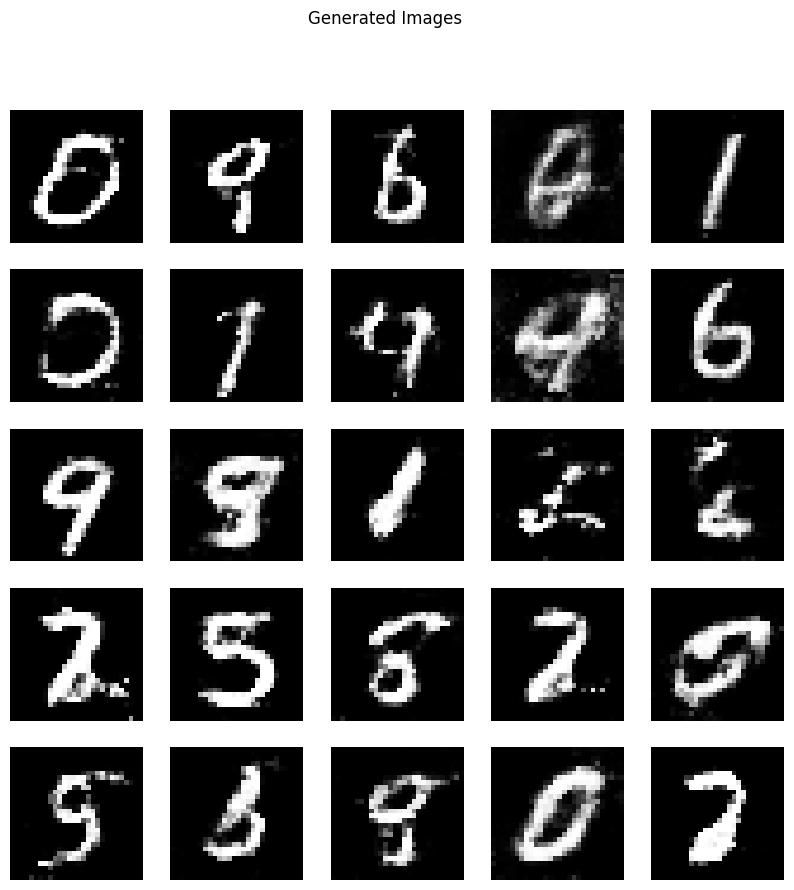

In [2]:
import torch
import matplotlib.pyplot as plt

# Function to display and save a batch of generated images
def show_generated_images(generator, latent_dim, n_images=25):
    generator.eval()  # Set the generator to evaluation mode
    z = torch.randn(n_images, latent_dim).cuda()  # Generate random noise
    with torch.no_grad():
        generated_images = generator(z).cpu()  # Generate images from the noise
    generator.train()  # Set the generator back to training mode

    # Plot the generated images in a grid
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Images')
    plt.show()

# Generate and visualize images
show_generated_images(generator, latent_dim, n_images=25)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Define the feature extractor network (acting as a discriminator)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

    def forward(self, img):
        features = self.model(img)
        return features

# MMD loss function
def mmd_loss(real_features, fake_features, kernel):
    mmd = torch.mean(kernel(real_features, real_features)) \
        + torch.mean(kernel(fake_features, fake_features)) \
        - 2 * torch.mean(kernel(real_features, fake_features))
    return mmd

# Gaussian kernel function
def gaussian_kernel(x, y, sigma=1.0):
    beta = 1.0 / (2.0 * sigma ** 2)
    dist = torch.cdist(x, y, p=2)
    return torch.exp(-beta * dist)

# Weight clipping function
def clip_weights(model, clip_value):
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

# Initialize networks and optimizers
latent_dim = 100
generator = Generator(latent_dim).cuda()
feature_extractor = FeatureExtractor().cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(feature_extractor.parameters(), lr=0.0002)

# Training loop
epochs = 50
clip_value = 1  # Define the clip value for weights

for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.cuda()

        # Generate fake images
        z = torch.randn(real_imgs.size(0), latent_dim).cuda()
        fake_imgs = generator(z)

        # Extract features
        real_features = feature_extractor(real_imgs)
        fake_features = feature_extractor(fake_imgs)

        # Compute MMD loss
        loss = mmd_loss(real_features, fake_features, gaussian_kernel)

        # Update generator
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

        # Clip weights of the feature extractor
        clip_weights(feature_extractor, clip_value)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5691077.48it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1103410.31it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9863260.48it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11825281.67it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Epoch 1/50, Loss: 0.06578847765922546
Epoch 2/50, Loss: 0.06448416411876678
Epoch 3/50, Loss: 0.06241040676832199
Epoch 4/50, Loss: 0.06000686436891556
Epoch 5/50, Loss: 0.06226452440023422
Epoch 6/50, Loss: 0.05843909829854965
Epoch 7/50, Loss: 0.06217329204082489
Epoch 8/50, Loss: 0.06451352685689926
Epoch 9/50, Loss: 0.05928020179271698
Epoch 10/50, Loss: 0.05632306635379791
Epoch 11/50, Loss: 0.060311608016490936
Epoch 12/50, Loss: 0.05949058383703232
Epoch 13/50, Loss: 0.0605255588889122
Epoch 14/50, Loss: 0.059537798166275024
Epoch 15/50, Loss: 0.057769775390625
Epoch 16/50, Loss: 0.06260111927986145
Epoch 17/50, Loss: 0.060845986008644104
Epoch 18/50, Loss: 0.05957917869091034
Epoch 19/50, Loss: 0.0592629536986351
Epoch 20/50, Loss: 0.058578163385391235
Epoch 21/50, Loss: 0.056806907057762146
Epoch 22/50, Loss: 0.058538466691970825
Epoch 23/50, Loss: 0.056476302444934845
Epoch 24/50, Loss: 0.060871317982673645
Epoch 25/50, Loss: 0.05891957879066467
Epoch 26/50, Loss: 0.057997658

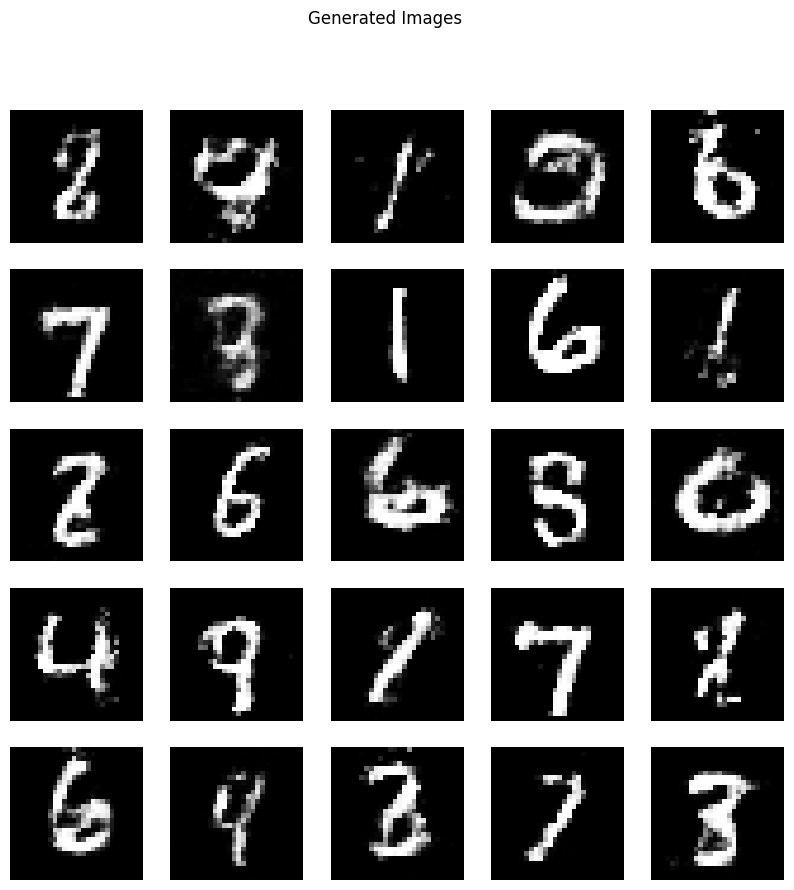

In [2]:
import torch
import matplotlib.pyplot as plt

# Function to display and save a batch of generated images
def show_generated_images(generator, latent_dim, n_images=25):
    generator.eval()  # Set the generator to evaluation mode
    z = torch.randn(n_images, latent_dim).cuda()  # Generate random noise
    with torch.no_grad():
        generated_images = generator(z).cpu()  # Generate images from the noise
    generator.train()  # Set the generator back to training mode

    # Plot the generated images in a grid
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Images')
    plt.show()

# Generate and visualize images
show_generated_images(generator, latent_dim, n_images=25)
